In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 
# norm
import scipy.stats as stats
# optimzie
import scipy.optimize as optimize
# integrate
import scipy.integrate as integrate
import math
# pde
import pde
sns.set_style('whitegrid')

In [2]:
df = pd.read_csv('./data/TSLA.csv')
# Date,Open,High,Low,Close,Adj Close,Volume
df = df.sort_values('Date')
df = df.reset_index(drop=True)
df = df.dropna()
df['Date'] = pd.to_datetime(df['Date'])
# just get the close price
df = df[['Date', 'Close']]
df = df.set_index('Date')
df = df.resample('D').ffill()
# np array
data = df['Close'].values
data = data.reshape(-1, 1)

In [3]:
# Estimate historical volatility of the data 
returns = np.log(data[1:] / data[:-1])
r_bar = np.mean(returns)
std = np.std(returns)
# 6 months = T
T = (1/2) * 252
N = len(returns)
volatility = np.sqrt ( (T / (N - 1)) * np.sum((returns - r_bar)**2) )
print('Historical Volatility:', volatility)

Historical Volatility: 0.2676814905073086


In [4]:
# Use the binomial tree approach to estimate the price of a Jun 2024 European call option , where 𝑟 = 0.05 ,
# 𝑆0 = 𝑐𝑢𝑟𝑟𝑒𝑛𝑡 𝑝𝑟𝑖𝑐𝑒 ,𝐾 = 𝑆0 + $50
# TTSLA Jun 21 2024 150.000 call
# prices = data
# r = 0.05
# S0 = prices[-1]
# K = S0 + 50
# T = 2
# sigma = 0.9390


prices = data
r = 0.05
S0 = prices[-1]
print('Current Price:', S0)
K = S0 + 50
# days until june 21 (trading days)
def trading_days_until_june_21():
    today = datetime.date.today()
    june_21 = datetime.date(today.year, 6, 21)
    if today > june_21:
        june_21 = datetime.date(today.year + 1, 6, 21)
    return (june_21 - today).days

days = trading_days_until_june_21()
T = days / 252 
sigma = volatility

# Binomial tree
def binomial_tree(S0, K, T, r, sigma, N, option_type='call'):
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)
    prices = np.zeros((N + 1, N + 1))
    prices[0, 0] = S0[0] if isinstance(S0, np.ndarray) else S0

    for i in range(1, N + 1):
        prices[i, 0] = prices[i - 1, 0] * u
        for j in range(1, i + 1):
            prices[i, j] = prices[i - 1, j - 1] * d
    option_prices = np.zeros((N + 1, N + 1))
    if option_type == 'call':
        option_prices[-1] = np.maximum(prices[-1] - K, 0)
    else:
        option_prices[-1] = np.maximum(K - prices[-1], 0)
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            option_prices[i, j] = np.exp(-r * dt) * (p * option_prices[i + 1, j] + (1 - p) * option_prices[i + 1, j + 1])
    return option_prices[0, 0]

print("number of trading days until june 21:", days)
N = 100
option_price = binomial_tree(S0, K, T, r, sigma, N)
print('Binomial Tree Option Price:', option_price)

Current Price: [147.050003]
number of trading days until june 21: 60
Binomial Tree Option Price: 0.12072420388849632


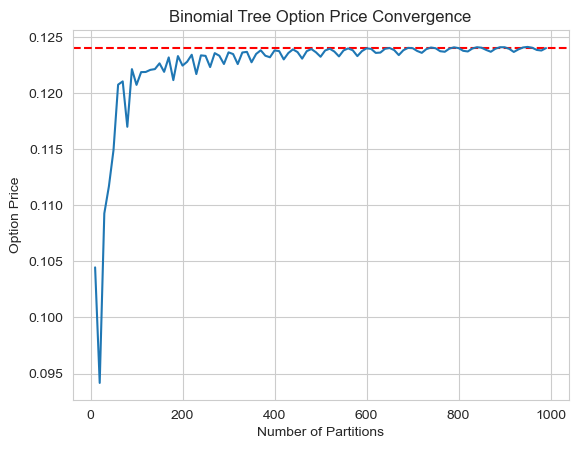

In [5]:
# Investigate the convergence rate of the binomial method as a function of the number of partitions of your time
# to expiration. Draw a graph

N = np.arange(10, 1000, 10)
option_prices = []
for n in N:
    option_price = binomial_tree(S0, K, T, r, sigma, n)
    option_prices.append(option_price)

# horizontal dashed red line for the converging price
plt.axhline(y=option_prices[-1], color='r', linestyle='--')
plt.plot(N, option_prices)
plt.xlabel('Number of Partitions')
plt.ylabel('Option Price')
plt.title('Binomial Tree Option Price Convergence')
plt.show()

In [6]:
# Use the binomial tree approach to estimate the price of a Jun 2024 American put option , where 𝑟 = 0.05 ,
# 𝑆0 = 𝑐𝑢𝑟𝑟𝑒𝑛𝑡 𝑝𝑟𝑖𝑐𝑒 ,𝐾 = 𝑆0 + $50
# TTSLA Jun 21 2024 150.000 put

K = S0 + 50
prices = data
r = 0.05
S0 = prices[-1]
T = days / 252
sigma = volatility
N = 100

option_price = binomial_tree(S0, K, T, r, sigma, N, option_type='put')
print('Binomial Tree Option Price:', option_price)

Binomial Tree Option Price: 47.78879888332742


In [7]:
# e) Use B-S formula to calculate the price of a Jun 2024 European call option , where 𝑟 = 0.05 , 𝑆0 =
# 𝑐𝑢𝑟𝑟𝑒𝑛𝑡 𝑝𝑟𝑖𝑐𝑒 ,𝐾 = 𝑆0 + $50. Use the put-call parity relation to calculate the price of a corresponding put
# option. Calculate the Delta, Gamma, Vega, rho of this option at the start of the option’s life.

def black_scholes(S0, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        price = S0 * stats.norm.cdf(d1) - K * np.exp(-r * T) * stats.norm.cdf(d2)
    else:
        price = K * np.exp(-r * T) * stats.norm.cdf(-d2) - S0 * stats.norm.cdf(-d1)
    return price


S0 = prices[-1]
K = S0 + 50
T = days / 252
r = 0.05
sigma = volatility

call_price = black_scholes(S0, K, T, r, sigma)
put_price = black_scholes(S0, K, T, r, sigma, option_type='put')
print('Black-Scholes Call Option Price:', call_price)
print('Black-Scholes Put Option Price:', put_price)

Black-Scholes Call Option Price: [0.12429466]
Black-Scholes Put Option Price: [47.79236934]


Delta: [0.01856343]


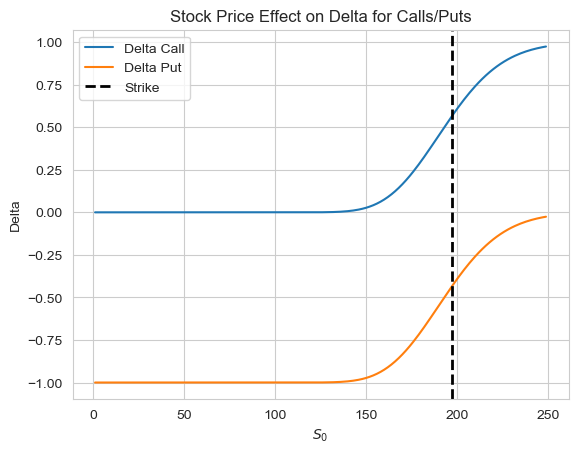

In [8]:
# Calculate the Delta, Gamma, Vega, rho of this option at the start of the option’s life.
from scipy.stats import norm
import numpy as np

def d1(S, K, T, r, sigma):
    return (np.log(S/K) + (r + sigma**2/2)*T) /\
                     (sigma*np.sqrt(T))

def d2(S, K, T, r, sigma):
    return d1(S, K, T, r, sigma) - sigma* np.sqrt(T)

def delta_call(S, K, T, r, sigma):
    N = norm.cdf
    return N(d1(S, K, T, r, sigma))
    

def delta_fdm_call(S, K, T, r, sigma, ds = 1e-5, method='central'):
    method = method.lower() 
    if method =='central':
        return (black_scholes(S+ds, K, T, r, sigma) -black_scholes(S-ds, K, T, r, sigma))/\
                        (2*ds)
    elif method == 'forward':
        return (black_scholes(S+ds, K, T, r, sigma) - black_scholes(S, K, T, r, sigma))/ds
    elif method == 'backward':
        return (black_scholes(S, K, T, r, sigma) - black_scholes(S-ds, K, T, r, sigma))/ds
    
def delta_fdm_put(S, K, T, r, sigma, ds = 1e-5, method='central'):
    method = method.lower() 
    if method =='central':
        return (black_scholes(S+ds, K, T, r, sigma, option_type='put') -black_scholes(S-ds, K, T, r, sigma, option_type='put'))/\
                        (2*ds)
    elif method == 'forward':
        return (black_scholes(S+ds, K, T, r, sigma, option_type='put') - black_scholes(S, K, T, r, sigma, option_type='put'))/ds
    elif method == 'backward':
        return (black_scholes(S, K, T, r, sigma, option_type='put') - black_scholes(S-ds, K, T, r, sigma, option_type='put'))/ds
    
def delta_put(S, K, T, r, sigma):
    return - norm.cdf(-d1(S, K, T, r, sigma))


S = S0
K = K
T = T
r = 0.05
sigma = volatility

delta = delta_call(S, K, T, r, sigma)

prices = np.arange(1, 250,1)

deltas_c = delta_call(prices, K, T, r, sigma)
deltas_p = delta_put(prices, K, T, r, sigma)
deltas_back_c = delta_fdm_call(prices, K, T,r, sigma, ds = 0.01,method='backward')
deltas_forward_p = delta_fdm_put(prices, K, T,r, sigma, ds = 0.01,method='forward')

plt.plot(prices, deltas_c, label='Delta Call')
plt.plot(prices, deltas_p, label='Delta Put')
plt.xlabel('$S_0$')
plt.ylabel('Delta')
plt.title('Stock Price Effect on Delta for Calls/Puts' )
plt.axvline(K, color='black', linestyle='dashed', linewidth=2,label="Strike")
plt.legend()

print('Delta:', delta)

Text(0, 0.5, 'FDM Error')

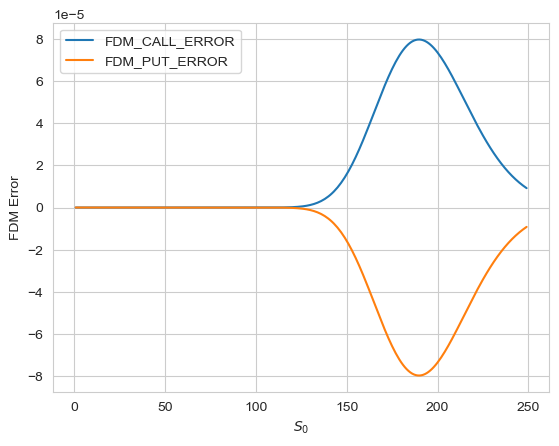

In [9]:
errorc = np.array(deltas_c) - np.array(deltas_back_c)
errorp = np.array(deltas_p) - np.array(deltas_forward_p)

plt.plot(prices, errorc, label='FDM_CALL_ERROR')
plt.plot(prices, errorp, label='FDM_PUT_ERROR')
plt.legend()
plt.xlabel('$S_0$')
plt.ylabel('FDM Error')

Gamma: [0.00184093]


Text(0, 0.5, 'Gamma')

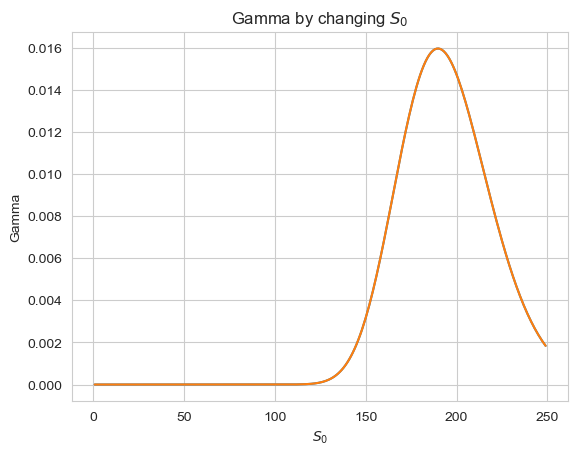

In [10]:
def gamma(S, K, T, r, sigma):
    N_prime = norm.pdf
    return N_prime(d1(S,K, T, r, sigma))/(S*sigma*np.sqrt(T))


def gamma_fdm(S, K, T, r, sigma , ds = 1e-5, method='central'):
    method = method.lower() 
    if method =='central':
        return (black_scholes(S+ds, K, T, r, sigma) -2*black_scholes(S, K, T, r, sigma) + 
                    black_scholes(S-ds, K, T, r, sigma) )/ (ds)**2
    elif method == 'forward':
        return (black_scholes(S+2*ds, K, T, r, sigma) - 2*black_scholes(S+ds, K, T, r, sigma)+
                   black_scholes(S, K, T, r, sigma) )/ (ds**2)
    
    elif method == 'backward':
        return (black_scholes(S, K, T, r, sigma) - 2* black_scholes(S-ds, K, T, r, sigma)
                + black_scholes(S-2*ds, K, T, r, sigma)) /  (ds**2)
    


gammas = gamma(prices, K, T, r, sigma)
gamma_forward = gamma_fdm(prices, K, T, r, sigma, ds =0.01,method='forward')
val = gamma_fdm(prices[-1], K, T, r, sigma, ds =0.01,method='backward')
print('Gamma:', val)
plt.plot(prices, gammas)
plt.plot(prices, gamma_forward)
plt.title('Gamma by changing $S_0$')
plt.xlabel('$S_0$')
plt.ylabel('Gamma')

In [11]:
def vega(S, K, T, r, sigma):
    N_prime = norm.pdf
    return S*np.sqrt(T)*N_prime(d1(S,K,T,r,sigma)) 

def vega_fdm(S, K, T, r, sigma, dv=1e-4, method='central'):
    method = method.lower() 
    if method =='central':
        return (black_scholes(S, K, T, r, sigma+dv) -black_scholes(S, K, T, r, sigma-dv))/\
                        (2*dv)
    elif method == 'forward':
        return (black_scholes(S, K, T, r, sigma+dv) - black_scholes(S, K, T, r, sigma))/dv
    elif method == 'backward':
        return (black_scholes(S, K, T, r, sigma) - black_scholes(S, K, T, r, sigma-dv))/dv
    
v = vega(S, K, T, r, sigma)
vegas = vega_fdm(prices, K, T, r, sigma, dv=0.01, method='forward')
print('Vega:', v)

Vega: [3.26089091]


Text(0.5, 1.0, 'Vega Decrease with Time')

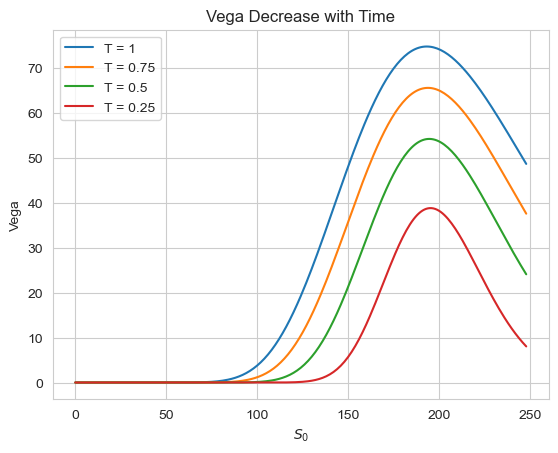

In [12]:

Ts = [1,0.75,0.5,0.25]

for t in Ts:
    plt.plot(vega(prices, K, t, r, sigma), label=f'T = {t}')

plt.legend()
plt.xlabel('$S_0$')
plt.ylabel('Vega')
plt.title('Vega Decrease with Time')

Theta: [-1.96332118]


Text(0, 0.5, 'Theta')

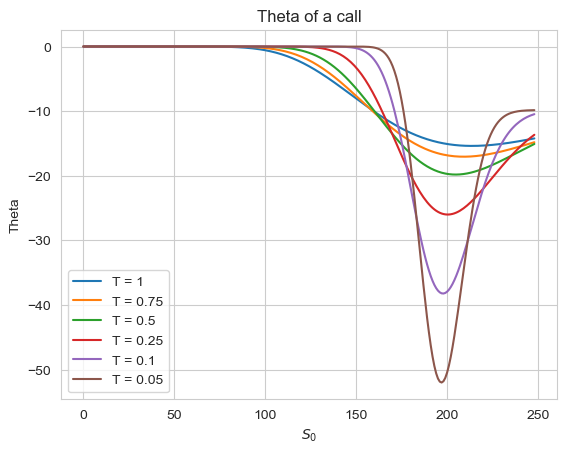

In [13]:
def theta_call(S, K, T, r, sigma):
    N_prime = norm.pdf
    p1 = -S*N_prime(d1(S, K, T, r, sigma))*sigma / (2 * np.sqrt(T))
    # p2 = r*K*np.exp(-r*T)*N(d2(S, K, T, r, sigma)) TypeError: 'int' object is not callable
    p2 = r*K*np.exp(-r*T)*norm.cdf(d2(S, K, T, r, sigma))
    return p1 - p2

def theta_put(S, K, T, r, sigma):
    N_prime = norm.pdf
    p1 = - S*N_prime(d1(S, K, T, r, sigma))*sigma / (2 * np.sqrt(T))
    p2 = r*K*np.exp(-r*T)*N(-d2(S, K, T, r, sigma)) 
    return p1 + p2

def theta_call_fdm(S, K, T, r, sigma, dt, method='central'):
    method = method.lower() 
    if method =='central':
        return (black_scholes(S, K, T-dt, r, sigma) -black_scholes(S, K, T+dt, r, sigma))/\
                        (2*dt)
    elif method == 'forward':
        return (black_scholes(S, K, T+dt, r, sigma) - black_scholes(S, K, T, r, sigma))/dt
    elif method == 'backward':
        return (black_scholes(S, K, T, r, sigma) - black_scholes(S, K, T-dt, r, sigma))/dt
    
def theta_put_fdm(S, K, T, r, sigma, dt, method='central'):
    method = method.lower() 

    if method =='central':
        return (black_scholes(S, K, T-dt, r, sigma, option_type='put') -black_scholes(S, K, T+dt, r, sigma, option_type='put'))/\
                        (2*dt)
    elif method == 'forward':
        return (black_scholes(S, K, T+dt, r, sigma, option_type='put') - black_scholes(S, K, T, r, sigma, option_type='put'))/dt
    elif method == 'backward':
        return (black_scholes(S, K, T, r, sigma, option_type='put') - black_scholes(S, K, T-dt, r, sigma, option_type='put'))/dt

# theta_call(100,100,1,0.05,0.2, 0.1,0.05)
val = theta_call(S, K, T, r, sigma)
print('Theta:', val)
Ts = [1,0.75,0.5,0.25,0.1,0.05]
for t in Ts:
    plt.plot(theta_call(prices, K, t, r, sigma), label=f'T = {t}')

plt.legend()
plt.title('Theta of a call')
plt.xlabel('$S_0$')
plt.ylabel('Theta')

In [14]:
def rho_call(S, K, T, r, sigma):
    # return K*T*np.exp(-r*T)*N(d2(S, K, T, r, sigma))
    return K*T*np.exp(-r*T)*norm.cdf(d2(S, K, T, r, sigma))

def rho_put(S, K, T, r, sigma):
    # return -K*T*np.exp(-r*T)*N(-d2(S, K, T, r, sigma))
    return -K*T*np.exp(-r*T)*norm.cdf(-d2(S, K, T, r, sigma))


def rho_call_fdm(S, K, T, r, sigma, dr, method='central'):
    method = method.lower() 
    if method =='central':
        return (black_scholes(S, K, T, r+dr, sigma) -black_scholes(S, K, T, r-dr, sigma))/\
                        (2*dr)
    elif method == 'forward':
        return (black_scholes(S, K, T, r+dr, sigma) - black_scholes(S, K, T, r, sigma))/dr
    elif method == 'backward':
        return (black_scholes(S, K, T, r, sigma) - black_scholes(S, K, T, r-dr, sigma))/dr
  
def rho_put_fdm(S, K, T, r, sigma, dr, method='central'):
    method = method.lower() 
    if method =='central':
        return (black_scholes(S, K, T, r+dr, sigma,  option_type='put') -black_scholes(S, K, T, r-dr, sigma, option_type='put'))/\
                        (2*dr)
    elif method == 'forward':
        return (black_scholes(S, K, T, r+dr, sigma, option_type='put') - black_scholes(S, K, T, r, sigma, option_type='put'))/dr
    elif method == 'backward':
        return (black_scholes(S, K, T, r, sigma, option_type='put') - black_scholes(S, K, T, r-dr, sigma, option_type='put'))/dr
    
val = rho_call(S, K, T, r, sigma)
print('Rho:', val)

Rho: [0.6203471]


Monte Carlo Option Price: 1.3675766985216844


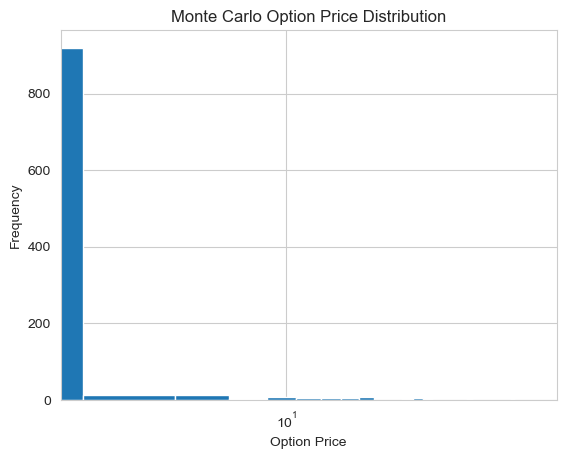

In [15]:
# Use a simple Monte Carlo method to estimate the price of a Jun 2024 European call option, where 𝑟 = 0.05
# 𝑆0 = 𝑐𝑢𝑟𝑟𝑒𝑛𝑡 𝑝𝑟𝑖𝑐𝑒 ,𝐾 = 𝑆0 + $50. Compare your answer with parts b) and e)

def monte_carlo(S0, K, T, r, sigma, N, option_type='call'):
    dt = T / N
    prices = np.zeros(N + 1)
    prices[0] = S0[0] if isinstance(S0, np.ndarray) else S0
    for i in range(1, N + 1):
        prices[i] = prices[i - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * np.random.normal())
    if option_type == 'call':
        payoff = np.maximum(prices[-1] - K, 0)
    else:
        payoff = np.maximum(K - prices[-1], 0)
    price = np.exp(-r * T) * np.mean(payoff)
    return price

S0 = prices[-1]
K = S0 + 50
T = days / 252
r = 0.05
sigma = volatility
N = 1000

option_price = monte_carlo(S0, K, T, r, sigma, N, option_type='call')

# plot a histogram of the option prices
option_prices = [monte_carlo(S0, K, T, r, sigma, N, option_type='call') for _ in range(1000)]
print('Monte Carlo Option Price:', np.mean(option_prices))

plt.hist(option_prices, bins=30)
plt.xscale('log')
plt.xlabel('Option Price')
plt.ylabel('Frequency')
plt.title('Monte Carlo Option Price Distribution')
plt.show()

Monte Carlo Antithetic Option Price: 0.0


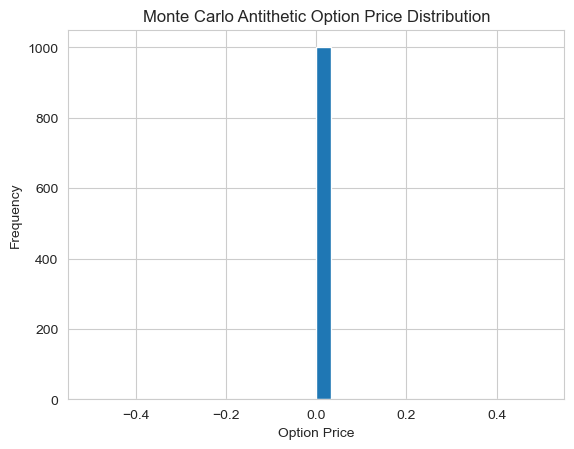

In [16]:
# g) Use a Monte Carlo method with Antithetic variates to estimate the price of a Jun 2024 European call option,
# where 𝑟 = 0.05 , 𝑆0 = 𝑐𝑢𝑟𝑟𝑒𝑛𝑡 𝑝𝑟𝑖𝑐𝑒 ,𝐾 = 𝑆0 + $50. 

def monte_carlo_antithetic(S0, K, T, r, sigma, N, option_type='call'):
    dt = T / N
    prices = np.zeros(N + 1)
    prices[0] = S0[0] if isinstance(S0, np.ndarray) else S0
    for i in range(1, N + 1):
        z1 = np.random.normal()
        z2 = -z1
        prices[i] = prices[i - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z1)
        prices[i] += prices[i - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z2)
        prices[i] /= 2
    if option_type == 'call':
        payoff = np.maximum(prices[-1] - K, 0)
    else:
        payoff = np.maximum(K - prices[-1], 0)
    price = np.exp(-r * T) * np.mean(payoff)
    return price

S0 = prices[-1]
K = S0 + 50
T = days / 252
r = 0.05
sigma = volatility
N = 1000

option_price = monte_carlo_antithetic(S0, K, T, r, sigma, N, option_type='call')

# plot a histogram of the option prices
option_prices = [monte_carlo_antithetic(S0, K, T, r, sigma, N, option_type='call') for _ in range(1000)]
print('Monte Carlo Antithetic Option Price:', np.mean(option_prices))

plt.hist(option_prices, bins=30)
plt.xlabel('Option Price')
plt.ylabel('Frequency')
plt.title('Monte Carlo Antithetic Option Price Distribution')
plt.show()

Mean Option Price: 1.9920095653348322


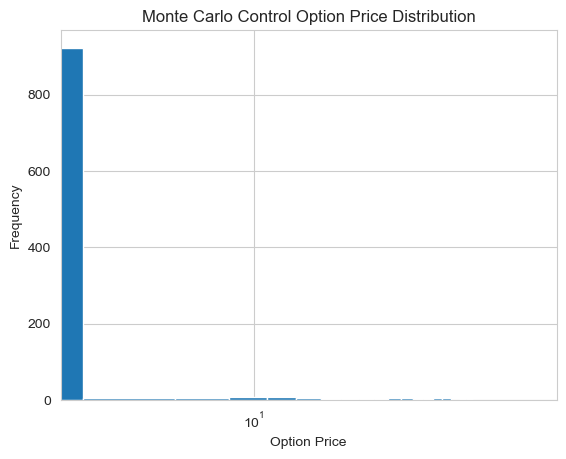

In [17]:
# Use a Monte Carlo method with Control variables to estimate the price of a Jun 2024 European call option,
# where 𝑟 = 0.05 , 𝑆0 = 𝑐𝑢𝑟𝑟𝑒𝑛𝑡 𝑝𝑟𝑖𝑐𝑒 ,𝐾 = 𝑆0 + $50. Compare f), g), h)

def monte_carlo_control(S0, K, T, r, sigma, N, option_type='call'):
    dt = T / N
    prices = np.zeros(N + 1)
    prices[0] = S0[0] if isinstance(S0, np.ndarray) else S0
    for i in range(1, N + 1):
        z = np.random.normal()
        prices[i] = prices[i - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
    if option_type == 'call':
        payoff = np.maximum(prices[-1] - K, 0)
    else:
        payoff = np.maximum(K - prices[-1], 0)
    price = np.exp(-r * T) * np.mean(payoff)
    return price

S0 = prices[-1]
K = S0 + 50
T = days / 252
r = 0.05
sigma = volatility
N = 1000

option_price = monte_carlo_control(S0, K, T, r, sigma, N, option_type='call')

# plot a histogram of the option prices
option_prices = [monte_carlo_control(S0, K, T, r, sigma, N, option_type='call') for _ in range(1000)]
print('Mean Option Price:', np.mean(option_prices))

plt.hist(option_prices, bins=30)
plt.xlabel('Option Price')
plt.xscale('log')
plt.ylabel('Frequency')
plt.title('Monte Carlo Control Option Price Distribution')
plt.show()

In [18]:
# i) Estimate the implied volatility for the problem in part e). How does it compare with the historical volatility?
 
def implied_volatility(S0, K, T, r, price, option_type='call'):
    def f(sigma):
        return black_scholes(S0, K, T, r, sigma, option_type) - price
    return optimize.newton(f, 0.5)

S0 = prices[-1]
K = S0 + 50
T = days / 252
r = 0.05
price = call_price

implied_vol = implied_volatility(S0, K, T, r, price)
print('Implied Volatility:', implied_vol)


Implied Volatility: [0.16362905]
